In [1]:
import os

import psycopg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

TABLE_NAME = "users_churn"

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "eda_experiment"
RUN_NAME = "eda"

ASSETS_DIR = "assets"

if not os.path.exists(ASSETS_DIR):
    os.mkdir(ASSETS_DIR)

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

In [4]:
f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

'http://127.0.0.1:5000'

In [5]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

df.head(5)

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,...,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,17,8191-XWSZG,2015-10-01,NaT,One year,No,Mailed check,20.65,1022.95,None,...,None,None,None,None,Female,0,No,No,No,0
1,21,8779-QRDMV,2019-11-01,2019-12-01,Month-to-month,Yes,Electronic check,39.65,39.65,DSL,...,Yes,No,No,Yes,Male,1,No,No,None,1
2,22,1680-VDCWW,2019-02-01,NaT,One year,No,Bank transfer (automatic),19.80,202.25,None,...,None,None,None,None,Male,0,Yes,No,No,0
3,23,1066-JKSGK,2019-11-01,2019-12-01,Month-to-month,No,Mailed check,20.15,20.15,None,...,None,None,None,None,Male,0,No,No,No,1
4,24,3638-WEABW,2015-04-01,NaT,Two year,Yes,Credit card (automatic),59.90,3505.10,DSL,...,No,Yes,No,No,Female,0,Yes,No,Yes,0


In [7]:
from sklearn.model_selection import train_test_split

cat_features = [
    'paperless_billing',
    'payment_method',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'multiple_lines',
]
num_features = ["monthly_charges", "total_charges"]

features = cat_features + num_features
target = 'target'

split_column = "begin_date"
test_size = 0.2

df = df.sort_values(by=[split_column])

X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df[target],
    test_size=test_size,
    shuffle=False,
) 

In [13]:
from autofeat import AutoFeatRegressor

transformations = ('1/', 'log', 'abs', 'sqrt')

afc = AutoFeatRegressor(categorical_cols=cat_features, feateng_steps=1, n_jobs=-1, transformations=transformations)

X_train_features = afc.fit_transform(X_train, y_train)
X_test_features = afc.transform(X_test)

In [24]:
artifact_path = "afc"

EXPERIMENT_NAME = "features_experiment"
RUN_NAME = "features"

if mlflow.get_experiment_by_name(EXPERIMENT_NAME):
    experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
else:
    experiment_id = mlflow.create_experiment(name=EXPERIMENT_NAME)

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    afc_info = mlflow.sklearn.log_model(afc, artifact_path=artifact_path) 

2024-05-23 11:45:01,068 INFO: Found credentials in environment variables.


In [25]:
run_id

'a1709364b5c442f6a5cc9d70516ba3e6'

In [26]:
mlflow.get_experiment_by_name(EXPERIMENT_NAME)

<Experiment: artifact_location='s3://s3-student-mle-20240325-d3a8040a07/6', creation_time=1716464697818, experiment_id='6', last_update_time=1716464697818, lifecycle_stage='active', name='features_experiment', tags={}>

In [27]:
from mlflow.tracking import MlflowClient
import mlflow.pyfunc

client = MlflowClient()

model_name = 'churn_model_nikolaistepanov'
 
model_version = client.get_latest_versions(name=model_name, stages=['Production'])[0]

model_uri = f"models:/{model_name}/{model_version.version}"
loaded_model = mlflow.pyfunc.load_model(model_uri)

2024/05/23 11:49:16 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - jupyterlab (current: 4.1.8, required: jupyterlab==4.0.7)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


In [32]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=300)

model.fit(X_train_features, y_train)

Learning rate set to 0.065015
0:	learn: 0.6462738	total: 65.9ms	remaining: 19.7s
1:	learn: 0.6070547	total: 74.9ms	remaining: 11.2s
2:	learn: 0.5730488	total: 81.5ms	remaining: 8.07s
3:	learn: 0.5477323	total: 91.6ms	remaining: 6.78s
4:	learn: 0.5244702	total: 103ms	remaining: 6.1s
5:	learn: 0.5049719	total: 108ms	remaining: 5.3s
6:	learn: 0.4903135	total: 117ms	remaining: 4.89s
7:	learn: 0.4741577	total: 129ms	remaining: 4.71s
8:	learn: 0.4607071	total: 148ms	remaining: 4.79s
9:	learn: 0.4548555	total: 152ms	remaining: 4.4s
10:	learn: 0.4442870	total: 161ms	remaining: 4.23s
11:	learn: 0.4356024	total: 171ms	remaining: 4.11s
12:	learn: 0.4282698	total: 178ms	remaining: 3.93s
13:	learn: 0.4215036	total: 183ms	remaining: 3.73s
14:	learn: 0.4161603	total: 188ms	remaining: 3.57s
15:	learn: 0.4108690	total: 197ms	remaining: 3.5s
16:	learn: 0.4062091	total: 206ms	remaining: 3.42s
17:	learn: 0.4024178	total: 211ms	remaining: 3.31s
18:	learn: 0.3985695	total: 223ms	remaining: 3.3s
19:	learn: 0

In [33]:
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, log_loss

prediction = model.predict(X_test_features)
probas = model.predict_proba(X_test_features)[:, -1]
# импортируйте необходимые вам модули

# заведите словарь со всеми метриками
metrics = {}

# посчитайте метрики из модуля sklearn.metrics
# err_1 — ошибка первого рода
# err_2 — ошибка второго рода
_, err1, _, err2 = _, err1, _, err2 = confusion_matrix(y_test, prediction, normalize='all').ravel() # ваш код здесь #
auc = roc_auc_score(y_test, probas) # ваш код здесь #
precision = precision_score(y_test, prediction) # ваш код здесь #
recall = recall_score(y_test, prediction) # ваш код здесь #
f1 = f1_score(y_test, prediction) # ваш код здесь #
logloss = log_loss(y_test, prediction) # ваш код здесь #

# запишите значения метрик в словарь
metrics["err1"] = err1
metrics["err2"] = err2
metrics["auc"] = auc
metrics["precision"] = precision
metrics["recall"] = recall
metrics["f1"] = f1
metrics["logloss"] = logloss

In [34]:
metrics

{'err1': 0.32292405961674947,
 'err2': 0.4088005677785664,
 'auc': 0.725919391800953,
 'precision': 0.5586808923375364,
 'recall': 0.8648648648648649,
 'f1': 0.6788450206246317,
 'logloss': 13.941654433689742}

In [36]:
REGISTRY_MODEL_NAME = "churn_model_nikolaistepanov"

pip_requirements = './requirements.txt'
signature = mlflow.models.infer_signature(X_test_features, prediction)
input_example = X_test[:10]
metadata = {'model_type': 'monthly'}

if mlflow.get_experiment_by_name(EXPERIMENT_NAME):
    experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
else:
    experiment_id = mlflow.create_experiment(name=EXPERIMENT_NAME)

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_params({"iterations": 300})
    mlflow.log_metrics(metrics)

    model_info = mlflow.catboost.log_model( 
        cb_model=model,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        pip_requirements=pip_requirements,
        signature=signature,
        input_example=input_example,
        metadata=metadata,
        await_registration_for=60,
    )

Registered model 'churn_model_nikolaistepanov' already exists. Creating a new version of this model...
2024/05/23 11:58:26 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: churn_model_nikolaistepanov, version 4
Created version '4' of model 'churn_model_nikolaistepanov'.


In [37]:
run_id

'db1d20ba80864308806816ff9535b55f'

In [38]:
model_version = client.get_latest_versions(name=model_name)[0]

model_uri = f"models:/{model_name}/{model_version.version}"
loaded_model = mlflow.pyfunc.load_model(model_uri)
loaded_model

2024/05/23 11:58:46 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - jupyterlab (current: 4.1.8, required: jupyterlab==4.0.7)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


mlflow.pyfunc.loaded_model:
  artifact_path: models
  flavor: mlflow.catboost
  run_id: 5dd819333df34c2ab8894c4b1b53a41e

In [39]:
model_version.version

'1'

In [6]:
RUN_NAME = "feature_selection"
FS_ASSETS = "fs_assets" 

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, 
    SplineTransformer, 
    QuantileTransformer, 
    RobustScaler,
    PolynomialFeatures,
    KBinsDiscretizer,
)

cat_columns = ["type", "payment_method", "internet_service", "gender"]

encoder_oh = OneHotEncoder(categories='auto', handle_unknown='ignore', sparse_output=False, max_categories=10, drop='first')
encoded_features = encoder_oh.fit_transform(df[cat_columns].to_numpy())

encoded_df = pd.DataFrame(encoded_features, columns=encoder_oh.get_feature_names_out())

obj_df = df.copy()
obj_df = pd.concat([obj_df, encoded_df], axis=1)

num_columns = ["monthly_charges", "total_charges"]

n_knots = 3
degree_spline = 4
n_quantiles=100
degree = 3
n_bins = 5
encode = 'ordinal'
strategy = 'uniform'
subsample = None

df[num_columns] = df[num_columns].fillna(df[num_columns].mean())
num_df = df[num_columns]


# SplineTransformer
encoder_spl = SplineTransformer(n_knots=n_knots, degree=degree_spline)
encoded_features = encoder_spl.fit_transform(df[num_columns].to_numpy())

encoded_df = pd.DataFrame(
    encoded_features, 
    columns=encoder_spl.get_feature_names_out(num_columns)
)
num_df = pd.concat([num_df, encoded_df], axis=1)


# QuantileTransformer
encoder_q = QuantileTransformer(n_quantiles=n_quantiles)
encoded_features = encoder_q.fit_transform(df[num_columns].to_numpy())

encoded_df = pd.DataFrame(
    encoded_features,
    columns=encoder_q.get_feature_names_out(num_columns)
)
encoded_df.columns = [col + f"_q_{n_quantiles}" for col in num_columns]
num_df = pd.concat([num_df, encoded_df], axis=1)


# RobustScaler
encoder_rb = RobustScaler()
encoded_features = encoder_rb.fit_transform(df[num_columns].to_numpy())

encoded_df = pd.DataFrame(
    encoded_features,
    columns=encoder_rb.get_feature_names_out(num_columns)
)
# encoded_df.columns = [col + f"_robust" for col in num_columns]
num_df = pd.concat([num_df, encoded_df], axis=1)


# PolynomialFeatures
encoder_pol = PolynomialFeatures(degree=degree)
encoded_features = encoder_pol.fit_transform(df[num_columns].to_numpy())

encoded_df = pd.DataFrame(
    encoded_features,
    columns=encoder_pol.get_feature_names_out(num_columns)
)
# encoded_df.columns = [encoded_df.columns[1 + len(num_columns):]]
num_df = pd.concat([num_df, encoded_df], axis=1)

# KBinsDiscretizer
encoder_kbd = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy, subsample=subsample)
encoded_features = encoder_kbd.fit_transform(df[num_columns].to_numpy())

encoded_df = pd.DataFrame(
    encoded_features,
    columns=encoder_kbd.get_feature_names_out(num_columns)
)
encoded_df.columns = [col + f"_bin" for col in num_columns]
num_df = pd.concat([num_df, encoded_df], axis=1)

numeric_transformer = ColumnTransformer(
    transformers=[
        ('spl', encoder_spl, num_columns),
        ('q', encoder_q, num_columns),
        ('rb', encoder_rb, num_columns),
        ('pol', encoder_pol, num_columns),
        ('kbd', encoder_kbd, num_columns)
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('encoder', encoder_oh)
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_columns),
        ('cat', categorical_transformer, cat_columns)
    ],
    n_jobs=-1
)

encoded_features = preprocessor.fit_transform(df)

transformed_df = pd.DataFrame(encoded_features, columns=preprocessor.get_feature_names_out())

df = pd.concat([df, transformed_df], axis=1)

In [9]:
from sklearn.model_selection import train_test_split

y = df['target']
X = transformed_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector

estimator = RandomForestClassifier(n_estimators=30)

In [19]:
sfs = SequentialFeatureSelector(estimator, forward=True, floating=False, cv=4, scoring='roc_auc', k_features=10, n_jobs=-1)
sbs = SequentialFeatureSelector(estimator, forward=False, floating=False, cv=4, scoring='roc_auc', k_features=10, n_jobs=-1)

In [20]:
sfs = sfs.fit(X_train, y_train)

In [21]:
sbs = sbs.fit(X_train, y_train)

In [22]:
top_sfs = sfs.k_feature_idx_
top_sbs = sbs.k_feature_idx_

print('\nSequential Forward Selection (k=10)')
print('CV Score:')
print(sfs.k_score_)

print('\nSequential Backward Selection')
print('CV Score:')
print(sbs.k_score_)


Sequential Forward Selection (k=10)
CV Score:
0.8133088921821225

Sequential Backward Selection
CV Score:
0.791862407317481


In [23]:
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T 

In [24]:
os.mkdir(FS_ASSETS)

sfs_df.to_csv(f"{FS_ASSETS}/sfs.csv")
sbs_df.to_csv(f"{FS_ASSETS}/sbs.csv") 

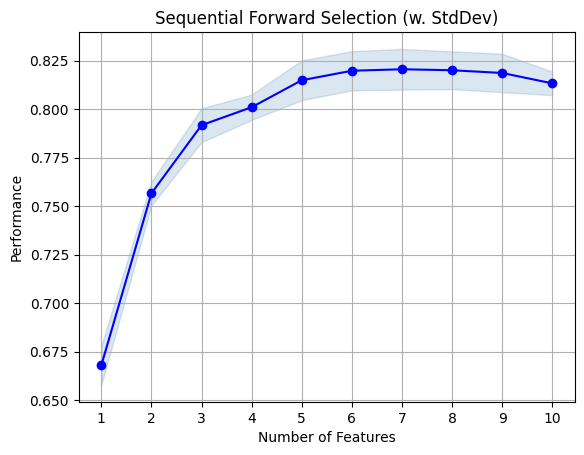

<Figure size 640x480 with 0 Axes>

In [26]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sfs.png") 

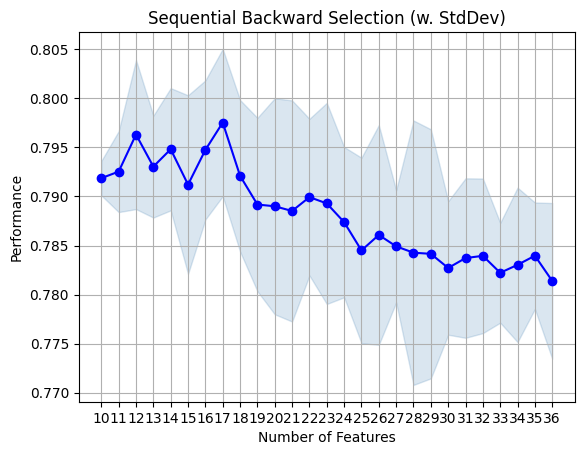

<Figure size 640x480 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sbs.png") 

In [28]:
interc_features = list(set(top_sbs) & set(top_sfs))
union_features = list(set(top_sbs) | set(top_sfs))

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=f"{RUN_NAME}_intersection_and_union", experiment_id=experiment_id) as run:
    run_id = run.info.run_id
   
    mlflow.log_artifacts(FS_ASSETS) 

In [29]:
run_id

'219eece134394ffd9dd2396022ffed56'

In [37]:
y = df['target']
X = transformed_df.iloc[:,interc_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [38]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=300)

model.fit(X_train, y_train)

Learning rate set to 0.060271
0:	learn: 0.6514481	total: 57.6ms	remaining: 17.2s
1:	learn: 0.6195381	total: 62.7ms	remaining: 9.35s
2:	learn: 0.5952686	total: 64.3ms	remaining: 6.37s
3:	learn: 0.5697230	total: 65.8ms	remaining: 4.87s
4:	learn: 0.5490950	total: 70.9ms	remaining: 4.18s
5:	learn: 0.5364013	total: 77.1ms	remaining: 3.78s
6:	learn: 0.5248156	total: 80.9ms	remaining: 3.38s
7:	learn: 0.5159331	total: 84.8ms	remaining: 3.1s
8:	learn: 0.5064591	total: 90.7ms	remaining: 2.93s
9:	learn: 0.5033361	total: 93.6ms	remaining: 2.71s
10:	learn: 0.4967164	total: 97.5ms	remaining: 2.56s
11:	learn: 0.4877295	total: 99.3ms	remaining: 2.38s
12:	learn: 0.4801432	total: 105ms	remaining: 2.31s
13:	learn: 0.4744437	total: 106ms	remaining: 2.17s
14:	learn: 0.4688962	total: 108ms	remaining: 2.05s
15:	learn: 0.4656116	total: 109ms	remaining: 1.94s
16:	learn: 0.4629797	total: 112ms	remaining: 1.87s
17:	learn: 0.4591248	total: 114ms	remaining: 1.78s
18:	learn: 0.4571910	total: 117ms	remaining: 1.73s


In [39]:
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, log_loss

prediction = model.predict(X_test)
probas = model.predict_proba(X_test)[:, -1]
# импортируйте необходимые вам модули

# заведите словарь со всеми метриками
metrics = {}

# посчитайте метрики из модуля sklearn.metrics
# err_1 — ошибка первого рода
# err_2 — ошибка второго рода
_, err1, _, err2 = _, err1, _, err2 = confusion_matrix(y_test, prediction, normalize='all').ravel() # ваш код здесь #
auc = roc_auc_score(y_test, probas) # ваш код здесь #
precision = precision_score(y_test, prediction) # ваш код здесь #
recall = recall_score(y_test, prediction) # ваш код здесь #
f1 = f1_score(y_test, prediction) # ваш код здесь #
logloss = log_loss(y_test, prediction) # ваш код здесь #

# запишите значения метрик в словарь
metrics["err1"] = err1
metrics["err2"] = err2
metrics["auc"] = auc
metrics["precision"] = precision
metrics["recall"] = recall
metrics["f1"] = f1
metrics["logloss"] = logloss

In [41]:
REGISTRY_MODEL_NAME = 'churn_model_nikolaistepanov'

pip_requirements = './requirements.txt'
signature = mlflow.models.infer_signature(X_test, prediction)
input_example = X_test[:10]
metadata = {'model_type': 'monthly'}

EXPERIMENT_NAME = 'feature_selection_interc'

if mlflow.get_experiment_by_name(EXPERIMENT_NAME):
    experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
else:
    experiment_id = mlflow.create_experiment(name=EXPERIMENT_NAME)

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_params({"iterations": 300})
    mlflow.log_metrics(metrics)

    model_info = mlflow.catboost.log_model( 
        cb_model=model,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        pip_requirements=pip_requirements,
        signature=signature,
        input_example=input_example,
        metadata=metadata,
        await_registration_for=60,
    )

Registered model 'churn_model_nikolaistepanov' already exists. Creating a new version of this model...
2024/05/23 22:48:27 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: churn_model_nikolaistepanov, version 5
Created version '5' of model 'churn_model_nikolaistepanov'.


In [42]:
y = df['target']
X = transformed_df.iloc[:,union_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [43]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=300)

model.fit(X_train, y_train)

Learning rate set to 0.060271
0:	learn: 0.6568409	total: 2.45ms	remaining: 732ms
1:	learn: 0.6210779	total: 4.58ms	remaining: 682ms
2:	learn: 0.5966012	total: 6.79ms	remaining: 673ms
3:	learn: 0.5753835	total: 8.96ms	remaining: 663ms
4:	learn: 0.5559890	total: 11.2ms	remaining: 659ms
5:	learn: 0.5401674	total: 13.2ms	remaining: 647ms
6:	learn: 0.5279896	total: 15.3ms	remaining: 639ms
7:	learn: 0.5164417	total: 17.3ms	remaining: 633ms
8:	learn: 0.5048470	total: 19.4ms	remaining: 627ms
9:	learn: 0.4928766	total: 21.4ms	remaining: 621ms
10:	learn: 0.4826725	total: 25.6ms	remaining: 673ms
11:	learn: 0.4750785	total: 27.8ms	remaining: 668ms
12:	learn: 0.4680630	total: 30.3ms	remaining: 668ms
13:	learn: 0.4615577	total: 33ms	remaining: 673ms
14:	learn: 0.4570959	total: 36.6ms	remaining: 695ms
15:	learn: 0.4523345	total: 40ms	remaining: 709ms
16:	learn: 0.4490669	total: 43.2ms	remaining: 719ms
17:	learn: 0.4457640	total: 46ms	remaining: 721ms
18:	learn: 0.4436613	total: 48.7ms	remaining: 720m

In [44]:
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, log_loss

prediction = model.predict(X_test)
probas = model.predict_proba(X_test)[:, -1]
# импортируйте необходимые вам модули

# заведите словарь со всеми метриками
metrics = {}

# посчитайте метрики из модуля sklearn.metrics
# err_1 — ошибка первого рода
# err_2 — ошибка второго рода
_, err1, _, err2 = _, err1, _, err2 = confusion_matrix(y_test, prediction, normalize='all').ravel() # ваш код здесь #
auc = roc_auc_score(y_test, probas) # ваш код здесь #
precision = precision_score(y_test, prediction) # ваш код здесь #
recall = recall_score(y_test, prediction) # ваш код здесь #
f1 = f1_score(y_test, prediction) # ваш код здесь #
logloss = log_loss(y_test, prediction) # ваш код здесь #

# запишите значения метрик в словарь
metrics["err1"] = err1
metrics["err2"] = err2
metrics["auc"] = auc
metrics["precision"] = precision
metrics["recall"] = recall
metrics["f1"] = f1
metrics["logloss"] = logloss

In [45]:
REGISTRY_MODEL_NAME = 'churn_model_nikolaistepanov'

pip_requirements = './requirements.txt'
signature = mlflow.models.infer_signature(X_test, prediction)
input_example = X_test[:10]
metadata = {'model_type': 'monthly'}

EXPERIMENT_NAME = 'feature_selection_union'

if mlflow.get_experiment_by_name(EXPERIMENT_NAME):
    experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
else:
    experiment_id = mlflow.create_experiment(name=EXPERIMENT_NAME)

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_params({"iterations": 300})
    mlflow.log_metrics(metrics)

    model_info = mlflow.catboost.log_model( 
        cb_model=model,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        pip_requirements=pip_requirements,
        signature=signature,
        input_example=input_example,
        metadata=metadata,
        await_registration_for=60,
    )

Registered model 'churn_model_nikolaistepanov' already exists. Creating a new version of this model...
2024/05/23 22:51:28 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: churn_model_nikolaistepanov, version 6
Created version '6' of model 'churn_model_nikolaistepanov'.


In [46]:
run_id

'57018dac82b847a29378dd86b9b2f094'

In [48]:
from mlflow.tracking import MlflowClient
import mlflow.pyfunc

client = MlflowClient()

model_name = 'churn_model_nikolaistepanov'
 
model_version = client.get_latest_versions(name=model_name)[0]

model_uri = f"models:/{model_name}/{model_version.version}"
loaded_model = mlflow.pyfunc.load_model(model_uri)

2024/05/23 23:00:12 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - jupyterlab (current: 4.1.8, required: jupyterlab==4.0.7)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


In [50]:
model_version.name

'churn_model_nikolaistepanov'

In [56]:

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute("select * from runs join model_versions on runs.run_uuid=model_versions.run_id where runs.name in ('churn_model_nikolaistepanov', 'churn_model_nikolaistepanov') and runs.run_uuid in ('17b7b9b08d1948a7b545de9810bc9698', '57018dac82b847a29378dd86b9b2f094')")
        result = cur.fetchall()

print(result)

[('5dd819333df34c2ab8894c4b1b53a41e', 'model_0_registry', 'UNKNOWN', '', '', 'mle-user', 'FINISHED', 1714857433405, 1714857434491, '', 'active', 's3://s3-student-mle-20240325-d3a8040a07/4/5dd819333df34c2ab8894c4b1b53a41e/artifacts', 4, None, 'churn_model_nikolaistepanov', 1, 1714857434438, 1714859690837, '', None, 'Staging', 's3://s3-student-mle-20240325-d3a8040a07/4/5dd819333df34c2ab8894c4b1b53a41e/artifacts/models', '5dd819333df34c2ab8894c4b1b53a41e', 'READY', None, ''), ('e7ffc6fd193f4a6492d921142f971f39', 'model_1_registry', 'UNKNOWN', '', '', 'mle-user', 'FINISHED', 1714859598312, 1714859599648, '', 'active', 's3://s3-student-mle-20240325-d3a8040a07/4/e7ffc6fd193f4a6492d921142f971f39/artifacts', 4, None, 'churn_model_nikolaistepanov_2', 1, 1714859599592, 1714859707328, '', None, 'Production', 's3://s3-student-mle-20240325-d3a8040a07/4/e7ffc6fd193f4a6492d921142f971f39/artifacts/models', 'e7ffc6fd193f4a6492d921142f971f39', 'READY', None, ''), ('71783d3bba9b40ac94c84513957aeb5e', 'mo